In [1]:
import os
import logging
logging.getLogger('tensorflow').disabled = True


import numpy as np
import tensorflow as tf
if not tf.test.is_gpu_available():
    print("GPU is not available, change Runtime!")

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.utils import plot_model

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:

import os
import time
import sys
import pandas as pd
from tensorflow.keras.models import save_model
from utils.data import train_val_generator,test_generator,pred_generator
from utils.imageplot import plot, plot2

In [6]:
train_gen = train_val_generator(
    data_dir='./imagenette/train',
    target_size=(32,32),
    batch_size=18,
    class_mode='sparse',
    subset='training'
)
#classes
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 7578 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [7]:
val_gen = train_val_generator(
data_dir='./imagenette/train',
    target_size=(32,32),
    batch_size=18,
    class_mode='sparse',
    subset='validation'
)

Found 1891 images belonging to 10 classes.


In [25]:
#regularized padded convolution
def r_p_c(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, padding='same', kernel_regularizer=_regularizer,
                                  kernel_initializer='he_normal', use_bias=False)
    
    
#original block
def o_block(x, filters, stride=1, **kwargs):
    l1 = r_p_c(filters, 3, strides=stride)(x)
    l1 = tf.keras.layers.BatchNormalization()(l1)
    l1 = tf.keras.layers.ReLU()(l1)
    l2 = r_p_c(filters, 3)(l1)
    l2 = tf.keras.layers.BatchNormalization()(l2)
    
    x = r_p_c(filters, 1, strides=stride)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x + l2)
    
#pre-activate block    
def p_block(x, filters, stride=1, p_block=False):
    inp = tf.keras.layers.BatchNormalization()(x)
    inp = tf.keras.layers.ReLU()(inp)
    if p_block:
        x = inp
        
    l1 = r_p_c(filters, 3, strides=stride)(inp)
    if _dropout:
        l1 = tf.keras.layers.Dropout(_dropout)(l1)
    
    l1 = tf.keras.layers.BatchNormalization()(l1)
    l1 = tf.keras.layers.ReLU()(l1)
    l2 = r_p_c(filters, 3)(l1)
    x = r_p_c(filters, 1, strides=stride)(x)
    return x + l2

#bottleneck_block
def b_block(x, filters, stride=1, p_block=False):
    inp = tf.keras.layers.BatchNormalization()(x)
    inp = tf.keras.layers.ReLU()(inp)
    if p_block:
        x = inp
         
    l1 = r_p_c(filters//_b_width, 1)(inp)
    l1 = tf.keras.layers.BatchNormalization()(l1)
    l1 = tf.keras.layers.ReLU()(l1)
    l2 = r_p_c(filters//_b_width, 3, strides=stride)(l1)
    l2 = tf.keras.layers.BatchNormalization()(l2)
    l2 = tf.keras.layers.ReLU()(l2)
    l3 = r_p_c(filters, 1)(l2)
    x = r_p_c(filters, 1, strides=stride)(x)
    return x + l3


def group_of_blocks(x, block_type, num_blocks, filters, stride, block_idx=0):
    global _p_shortcuts
    p_block = True if _p_shortcuts or block_idx == 0 else False
    
    x = block_type(x, filters, stride, p_block=p_block)
    for i in range(num_blocks-1):
        x = block_type(x, filters)
    return x


def Resnet(input_shape, n_classes, l2_reg=1e-4, 
           group_sizes=(2, 2, 2), features=(16, 32, 64), 
           strides=(1, 2, 2), block_type='preactivated', 
           first_conv={"filters": 16, "kernel_size": 3, "strides": 1},
           dropout=0, b_width=4, p_shortcuts=True):
    
    global _regularizer, _dropout, _b_width, _p_shortcuts
    _b_width = b_width # used in bottleneck blocks
    _regularizer = tf.keras.regularizers.l2(l2_reg)
    _dropout = dropout # used in Wide ResNets
    _p_shortcuts = p_shortcuts
    
    block_types = {'preactivated': p_block,
                   'bottleneck': b_block,
                   'original': o_block}
    
    selected_block = block_types[block_type]
    inputs = tf.keras.layers.Input(shape=input_shape)
    inp = r_p_c(**first_conv)(inputs)
    
    if block_type == 'original':
        inp = tf.keras.layers.BatchNormalization()(inp)
        inp = tf.keras.layers.ReLU()(inp)
    for block_idx, (group_size, feature, stride) in enumerate(zip(group_sizes, features, strides)):
        inp = group_of_blocks(inp,
                              block_type=selected_block,
                              num_blocks=group_size,
                              block_idx=block_idx,
                              filters=feature,
                              stride=stride)
    
    if block_type != 'original':
        inp = tf.keras.layers.BatchNormalization()(inp)
        inp = tf.keras.layers.ReLU()(inp)
    
    inp = tf.keras.layers.GlobalAveragePooling2D()(inp)
    outputs = tf.keras.layers.Dense(n_classes, kernel_regularizer=_regularizer)(inp)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def resnet20(block_type='original', l2_reg=1e-4):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, 
                   l2_reg=l2_reg, group_sizes=(3, 3, 3), 
                   features=(16, 32, 64), strides=(1, 2, 2), 
                   first_conv={"filters": 16, "kernel_size": 3, "strides": 1},  
                   block_type=block_type, p_shortcuts=False)
    return model


def resnet110(block_type='preactivated', l2_reg=1e-4):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, 
                   l2_reg=l2_reg, group_sizes=(18, 18, 18), 
                   features=(16, 32, 64), strides=(1, 2, 2), 
                   first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, 
                   block_type=block_type, p_shortcuts=False)
    return model


def resnet164(block_type='bottleneck', l2_reg=1e-4):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, 
                   l2_reg=l2_reg, group_sizes=(18, 18, 18), 
                   features=(64, 128, 256), strides=(1, 2, 2), 
                   first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, 
                   block_type=block_type, p_shortcuts=True)
    return model


def wide_resnet(N, K, block_type='preactivated', dropout=0, l2_reg=2.5e-4):
    assert (N-4) % 6 == 0, "N-4 has to be divisible by 6"
    # layers per block - since N is total number of convolutional layers in Wide ResNet
    lpb = (N-4) // 6 
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, 
                   l2_reg=l2_reg, group_sizes=(lpb, lpb, lpb), 
                   features=(16*K, 32*K, 64*K), strides=(1, 2, 2), 
                   first_conv={"filters": 16, "kernel_size": 3, "strides": 1}, 
                   block_type=block_type, dropout=dropout, p_shortcuts=True)
    return model


def w_16_4(dropout=0, l2_reg=2.5e-4):
    model = wide_resnet(16, 4, 'preactivated', dropout=dropout, l2_reg=l2_reg)
    return model


def w_40_4(dropout=0, l2_reg=2.5e-4):
    model = wide_resnet(40, 4, 'preactivated', dropout=dropout, l2_reg=l2_reg)
    return model


In [29]:
model = w_40_4()

In [30]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[400, 32000, 48000], 
                                                                values=[0.01, 0.1, 0.01, 0.001])
optimizer = tf.keras.optimizers.SGD(schedule, momentum=0.9)

model.compile(optimizer, loss_fn, metrics=['accuracy'])
checkpoint_save_path = './checkpoint/WRN16-4.ckpt'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                    save_weights_only=True,
                                                    save_best_only=True)
#history = model.fit(train_gen, steps_per_epoch=421, epochs=5, validation_data=val_gen, callbacks=[cp_callback])

In [31]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_430 (Conv2D)             (None, 32, 32, 16)   432         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_316 (BatchN (None, 32, 32, 16)   64          conv2d_430[0][0]                 
__________________________________________________________________________________________________
re_lu_307 (ReLU)                (None, 32, 32, 16)   0           batch_normalization_316[0][0]    
____________________________________________________________________________________________

In [88]:
history = model.fit(train_gen, steps_per_epoch=421, epochs=20, validation_data=val_gen, callbacks=[cp_callback])
model.load_weights(checkpoint_save_path)

Epoch 1/20
421/421 [==============================] - 19s 45ms/step - loss: 4.6739 - accuracy: 0.3770 - val_loss: 193.0647 - val_accuracy: 0.0904
Epoch 2/20
421/421 [==============================] - 18s 43ms/step - loss: 4.0931 - accuracy: 0.3380 - val_loss: 5.5810 - val_accuracy: 0.1787
Epoch 3/20
421/421 [==============================] - 18s 44ms/step - loss: 3.1969 - accuracy: 0.4173 - val_loss: 3.0533 - val_accuracy: 0.3892
Epoch 4/20
421/421 [==============================] - 19s 44ms/step - loss: 2.5707 - accuracy: 0.4893 - val_loss: 2.5334 - val_accuracy: 0.4606
Epoch 5/20
421/421 [==============================] - 19s 44ms/step - loss: 2.1618 - accuracy: 0.5484 - val_loss: 2.0579 - val_accuracy: 0.5489
Epoch 6/20
421/421 [==============================] - 19s 45ms/step - loss: 1.8911 - accuracy: 0.5764 - val_loss: 2.2614 - val_accuracy: 0.4754
Epoch 7/20
421/421 [==============================] - 19s 45ms/step - loss: 1.7044 - accuracy: 0.6074 - val_loss: 2.5920 - val_accurac

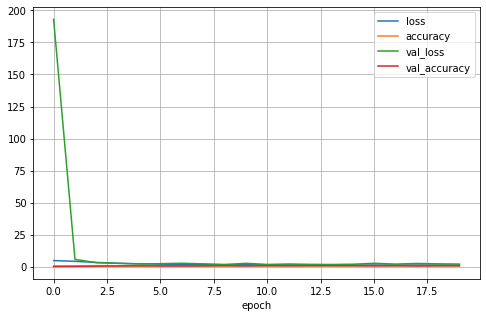

In [89]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [27]:
test_gen = test_generator(
    data_dir='./imagenette/val',
    target_size=(32,32),
    batch_size=18,
    class_mode='sparse'
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 3925 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [28]:
pred_gen = pred_generator(
    data_dir='./imagenette/val',
    target_size=(32,32),
    batch_size=18,
    class_mode=None
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 3925 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


219/219 [==============================] - 4s 16ms/step - loss: 1.5748 - accuracy: 0.6234
the loss of test set：1.5748342275619507，accuracy:0.6234394907951355
result of the pred set one batch 15 pictures： [[ 2.8678265  -0.33838332 -1.9973308   0.9180105  -0.14243174 -1.0270698
   0.76747787 -1.8835897   1.0221767  -0.20544407]
 [ 0.2071772   1.5475554  -0.17545131  1.173157   -1.8237295   0.37530714
  -0.2303126   1.8176286  -0.73880386 -2.114386  ]
 [-2.9876578  -1.0901927   2.1786575  -0.20198667  0.12706375 -2.439916
   7.5599566   1.5649309  -1.3691181  -3.1063075 ]
 [-5.4051094  -1.2093769   7.2085657  -2.4681823   0.62792575 -0.6490501
   0.8168137   6.7226663  -1.0657314  -4.4092126 ]
 [-1.1899406   0.33510813  0.41151643  1.1010151  -0.535634   -0.24148518
   1.6669959   1.8659761  -0.9017348  -2.4024162 ]
 [ 0.32844377  0.5092646  -0.9907092  -0.10204786  0.02147981 -0.6388042
  -0.4594794  -0.72146714  2.4535232  -0.41109675]
 [-0.4113651  -0.29503357  1.3735654   0.9210975  -

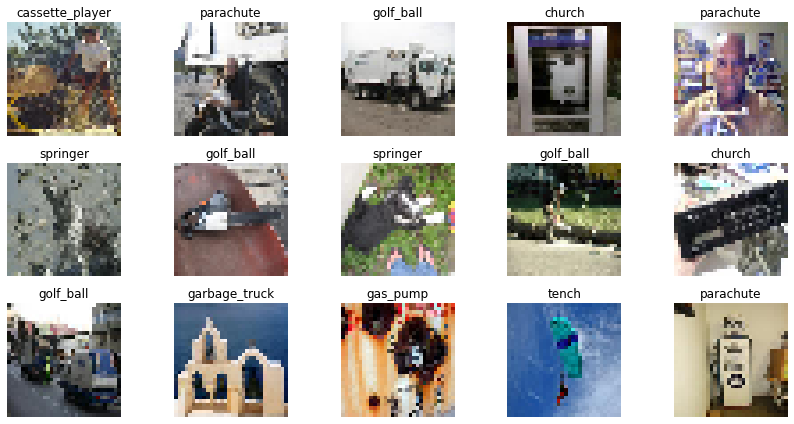

In [90]:
loss, accuracy = model.evaluate(x=test_gen)
print('the loss of test set：{0}，accuracy:{1}'.format(loss,accuracy))
#get pred set of a batch size
pred_batch = pred_gen.next()
#use the model to predict the pred set
pred_result = model.predict(x=pred_batch)
print('result of the pred set one batch 15 pictures：',pred_result)
#visualization
plot(pred_batch,pred_result)